# Импорт модулей и библиотек

In [2]:
import pandas as pd
import numpy as np
import pickle
import datetime as d
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds

!pip install implicit
from implicit.nearest_neighbours import CosineRecommender, BM25Recommender, TFIDFRecommender
from implicit.als import AlternatingLeastSquares
from implicit.lmf import LogisticMatrixFactorization
from implicit.bpr import BayesianPersonalizedRanking

!pip install comet_ml
from comet_ml import Experiment

from math import log2

import warnings
warnings.filterwarnings("ignore")

# Data Preprocessing

In [3]:
def extraction_data(path_new_data: str, all_years_df = pd.DataFrame([])):

    # load data 2015-2021 years
    for year in range(2015, 2022):
        with open(f"C:/Users/pasin/RecSys_V2/Data/df_{year}_cleaned.pickle", "rb") as file:
            df_years = pickle.load(file)
        all_years_df = all_years_df.append(df_years, ignore_index=True)

    all_years_df.rename(columns={"deals": "amount"}, inplace=True)
    all_years_df.drop("date", axis=1, inplace=True)
    
    # load data 2022 years
    df_2022 = pd.read_csv(f"{path_new_data}", sep=";")

    # Some transforms for data 
    df_2022["datetime"] = pd.to_datetime(df_2022["timestamp"])
    df_2022["cf"] = -df_2022["amount"]*df_2022["price"]
    df_2022.rename(columns={"id": "user"}, inplace=True)

    df_2022 = df_2022.reindex(columns=["datetime", "ticker", "amount", "price", "user", "cf"])

    df_result = pd.concat([df_2022, all_years_df]).reset_index(drop = True)
    df_result["volume"] = abs(df_result["cf"])
    
    tick2ind = {ticker:i for i, ticker in enumerate(df_result.ticker.unique())}
    ind2tick = {val:key for key, val in tick2ind.items()}
    df_result["ticker_id"] = df_result["ticker"].apply(lambda x: tick2ind[x])

    user2ind = {user:i for i, user in enumerate(df_result.user.unique())}
    ind2user = {val:key for key, val in user2ind.items()}
    df_result["user_id"] = df_result["user"].apply(lambda x: user2ind[x])
    df_result.groupby(["ticker_id", "user_id", "datetime"], as_index=False)["volume"].sum()
    df_result["year"] = df_result["datetime"].apply(lambda row: row.year)
    
    df_result.sort_values("datetime", inplace = True)
    return df_result.reset_index(drop = True)

In [26]:
df_result = extraction_data("C:/Users/pasin/RecSys_V2/Data/stock_market_trades.csv")

KeyboardInterrupt: 

In [6]:
#df_result = pd.read_csv("../Data/Result_data/resultData.csv", index_col=0)
tick2ind = {ticker:i for i, ticker in enumerate(df_result.ticker.unique())}
ind2tick = {val:key for key, val in tick2ind.items()}
user2ind = {user:i for i, user in enumerate(df_result["user"].unique())}
ind2user = {val:key for key, val in user2ind.items()}
print(user2ind["1_95110"])

10729


In [27]:
df_result.head(5)

,datetime,ticker,amount,price,user,cf,volume,ticker_id,user_id,year
0,2015-09-16 10:00:00,LKOH,5,2485.10,1_48198,-12425.5,12425.5,4,8851,2015
1,2015-09-16 10:00:00,SBER,100,75.12,1_48199,-7512.0,7512.0,23,8951,2015
2,2015-09-16 10:00:00,SBER,10,75.25,1_49493,-752.5,752.5,23,3355,2015
3,2015-09-16 10:00:00,LKOH,38,2485.10,1_48198,-94433.8,94433.8,4,8851,2015
4,2015-09-16 10:00:00,SBER,-200,75.23,1_48670,15046.0,15046.0,23,7243,2015


## train-test-split

### Создаем словарь (Дата сделки: сделка)

In [8]:
def date_deals(df, data):    
    
    """
    Функция получает на вход столбец датафрейма с датами сделок
    
    На выходе: словарь с ключами - Дата сделки, а значения - сами сделки
    """
    
    date_deal = {}
    dates=set(data.values)
    
    for d in dates:
        deals = df[(data==d)]
        if len(deals)==1:
            continue
        else:
            date_deal[d] = deals    
            
    return date_deal

# Train_test_split

In [9]:
def train_test_split(df, train_size=0.7, test_size=0.3):
    
    train = pd.DataFrame()
    test = pd.DataFrame()
    dict_date = date_deals(df, df["year"])
    
    for key in dict_date.keys():
        deals_count = len(dict_date[key])
        to_train = round(deals_count*train_size)
        to_test = round(deals_count*test_size)
            
        train = pd.concat([train, dict_date[key][:to_train]])
        test = pd.concat([test, dict_date[key][-to_test:]])
    return (train, test)

In [10]:
%%time
train, test = train_test_split(df_result, train_size=0.7, test_size=0.3)

Wall time: 2.89 s


# Сбор матриц

In [11]:
def get_csr_matrix(df, user_col, ticker_col, add_col, csr_method):
    n_rows = df[user_col].nunique()
    n_cols = df[ticker_col].nunique()

    row = df[user_col] #user
    col = df[ticker_col] #ticker
    data = df[add_col].astype(float) #deals
    
    return csr_method((data, (row, col)))

In [12]:
csr_train = get_csr_matrix(train, "user_id", "ticker_id", "volume", csr_matrix)
csr_test = get_csr_matrix(test, "user_id", "ticker_id", "volume", csr_matrix)

# Обучение

Параметр K влияет на максимальную выдачу топа, поэтому N для таких моделей желательно указывать меньше K

In [13]:
def recommend_tick(user, model, train_matrix, N):
    user_id = user2ind[user]

    recs = model.recommend(user_id, train_matrix[user_id], N=N, filter_already_liked_items=True)
    
    res = [ind2tick[ticker_ids] for ticker_ids in recs[0]]
    return res

In [14]:
def find_similar(user, model, train_matrix, N):
    user_id = user2ind[user]

    recs = model.recommend(user_id, train_matrix[user_id], N=N, filter_already_liked_items=True)
    
    res = recs[1]
    return res

In [15]:
def get_recommenders(model, csr_matrix_train, df_test, 
                     k=20, factors=40, regularization=0.1, iterations=20,
                     top_N = 10):
    
    if model == CosineRecommender or model == TFIDFRecommender:
        fitting_model = model(K=k)
    elif model == AlternatingLeastSquares or model == LogisticMatrixFactorization or model == BayesianPersonalizedRanking:
        fitting_model = model(factors=factors, regularization=regularization, iterations=iterations)
    
    fitting_model.fit(csr_matrix_train)

    df_reccomeds = pd.DataFrame({'user': df_test['user'].unique()})
    
    df_reccomeds['ticker'] = df_reccomeds['user'].apply(lambda x: 
                                                            recommend_tick(x, 
                                                                           fitting_model, 
                                                                           csr_matrix_train, 
                                                                           top_N))
    df_reccomeds['similar'] = df_reccomeds['user'].apply(lambda x: find_similar(x, 
                                                                                fitting_model, 
                                                                                csr_matrix_train, 
                                                                                top_N))
    
    df_reccomeds = df_reccomeds.explode(["similar", "ticker"])
    df_reccomeds["rank"] = -(df_reccomeds.groupby('user')["similar"].rank()-11)
        
    return df_reccomeds

# Метрики

In [43]:
def MRR(test_data, predict_data):

    '''
    RR - обратный ранг: 1 / индеск первого вхождения рекомендации в тест

    На вход подается:
        - test_data - тестовый набор данных
        - predict_data - предсказания

    k берется таким, для которого мы рассчитывали рекомендации (длина рекомендаций)

    На выходе:
        Метрика MRR@k по всем пользователям
    '''

    sum_rr = 0
    # находим порядковый номер первого вхождения правильной рекомендации в тест
    for user in test_data.index.unique():
        rank = []
        if user in predict_data.index.unique() and not type(predict_data.ticker[user])==float:
            rank = [1 + list(predict_data['ticker'][user]).index(x) for x in \
                    set(predict_data['ticker'][user]).intersection(set(test_data['ticker'][user]))]
            
            # находим обратный ранк, если попадания нет, то зануляем
            if len(rank) == 0:
                rr = 0
            else:
                rr = 1 / min(rank)

            sum_rr += rr
    
    # находим среднее по пользователям
    return sum_rr / len(test_data.index.unique())

In [18]:
def mean_average_precision(test_data, predict_data):

    '''
    Mean Average Precision - средняя точность по пользователям

    На вход:
        - test_data - тестовый набор данных
        - predict_data - предсказания

    k берется таким, для которого мы рассчитывали рекомендации (длина рекомендаций)

    На выходе:
        Метрика MAP@k по всем пользователям
    '''

    sum_ap = 0

    # итерируемся по пользователям
    for user in test_data.index.unique():
        
        if user in predict_data.index and not type(predict_data.ticker[user])==float:
            num_hits = 0
            score = 0
            
            for i, p in enumerate(predict_data['ticker'][user]):

                if p in test_data['ticker'][user] and p not in predict_data['ticker'][user][:i]:
                    num_hits += 1
                    score += num_hits / (i + 1)

            sum_ap += score / min(len(test_data['ticker'][user]), len(predict_data['ticker'][user]))


    # находим среднее по пользователям
    return sum_ap / len(test_data.index.unique())

In [19]:
def mean_average_recall(test_data, predict_data):

    '''
     На вход подается:
         - test_data - тестовый набор данных
         - predict_data - предсказания

     k берется таким, для которого мы рассчитывали рекомендации (длина рекомендаций)

     На выходе:
         Метрика MAR@k по всем пользователям
    '''

    sum_recall = 0

    # вычисляем метрику по каждому пользователю
    for user in test_data.index.unique():
        if user in predict_data.index and not type(predict_data.ticker[user])==float:

            TP = len(set(predict_data['ticker'][user]).intersection(set(test_data['ticker'][user])))
            TP_FN = len(test_data['ticker'][user])

            sum_recall += TP / TP_FN

    # находим среднее по пользователям
    return sum_recall / len(test_data.index.unique())

In [44]:
def NDCG(test_data, predict_data):
    
    '''
    NDCG - метрика, равная сумме выражений вида 1/log2(k_true+1), деленная на 1/log2(k_all+1) по всем пользователям,
        где k_true - ранг правильно предсказанных акций, k_all - все ранги
    
    
    На вход подается: 
        - test_data - тестовый набор данных 
        - predict_data - предсказания модели
    
    k берется равным длине рассчитанных рекомендаций 
    
    На выходе: 
        Метрика NDCG по всем пользователям
    '''
    
    dcg = 0
    idcg = 0
    
    for user in test_data.index.unique():
        if user in predict_data.index and not type(predict_data.ticker[user])==float:
            
            # определяем ранги правильно предсказанных акций
            rec_ranks = [1 + list(predict_data['ticker'][user]).index(x) for x in \
                    set(predict_data['ticker'][user]).intersection(set(test_data['ticker'][user]))]
            
            dcg += sum([ 1 / log2(r+1) for r in rec_ranks]) # сумма по правильно предсказанным акциям 
            idcg += sum([ 1 / log2(r+1) for r in range(1, 11)]) # максимально возможная сумма
                
    ndcg = dcg/idcg
    
    return ndcg / (test_data.index.nunique())

In [21]:
def calculate_metrics(test_data, predict_data, metrics=[]):
    
    '''
    На вход подается:
        test_data - тестовый набор данных
        predict_data - рекомендации для пользователя
        metrics - список нужных метрик 
    
    На выходе:
        Вычисленная таблица с результатами 
    '''
    
    if len(metrics) == 0:
        raise ValueError('metrics are empty')
        
    results = []
    for metric in metrics:
        results.append(metric(test_data, predict_data))
    
    return results

In [37]:
t = d.datetime.now()
print(t)
test.set_index(test.user.apply(lambda x: user2ind[x]), inplace = True)
recs = get_recommenders(CosineRecommender, csr_train, test)
recs.set_index(recs.user.apply(lambda x: user2ind[x]), inplace=True)
t = d.datetime.now()
print(MRR_num(test, recs), d.datetime.now()-t)

2023-03-15 08:46:39.208210


  0%|          | 0/161 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 1, got 0)

In [24]:
models = {"cosine": CosineRecommender,
          "tfidf": TFIDFRecommender, 
          "als": AlternatingLeastSquares,
          "lmf": LogisticMatrixFactorization,
          "bpr": BayesianPersonalizedRanking}

metrics = {"MRR": MRR, "NDCG": NDCG, "MAP": mean_average_precision}
metrics = [MRR, NDCG, mean_average_precision]

hyperparameters = {"K": [20], # количество соседей для подбора айтемов для рекомендаций
                   "fact": [35, 45], # количество скрытых факторов
                   "regul": [3.5, 4, 4,5], # параметр регуляризации
                   "iter": [20, 35] # количество итераций для подбора матриц
                   }


In [23]:
def comparing_models(compare_models, train, test, models, metrics, hyperparameters):
    
    '''
    На вход подается: 
        compare_models - датафрейм для сравнения метрик моделей с различными гиперпараметрами
        train - набор данных для обучения модели
        test - тестовый набор данных
        models - словарь обучаемых моделей с их алиасами
        metrics - список метрик 
        metrics - словарь со списками значений по каждому гиперпараметру для сравнения модели
        
    На выходе: 
        Датафрейм с заполненными данными по каждой модели    
    '''
    
    t = d.datetime.now()
    
    # корректировка датафреймов 
    test.set_index(test.user.apply(lambda x: user2ind[x]), inplace = True)

    for model_name, model in models.items():
        
        if model == CosineRecommender or model == TFIDFRecommender:
            for k in hyperparameters["K"]:
                # создаем эксперимент для логирования метрик в comet ml
                experiment = Experiment(
                    api_key="5KHdGGECPvjMaU1x9uobLnGyb",
                    project_name="RecSysTop",
                    workspace="pashinskaya03",
                )
                parameters = {'K': k}
                experiment.log_parameters(parameters) # логирование гиперпараметров
                
                # создаем строку для добавления в датафрейм
                row = [model_name]
                row += [k, None, None, None]
                
                fitting_model = model(K=k)

                recs = get_recommenders(model, train, test) 
                recs.set_index(recs.user.apply(lambda x: user2ind[x]), inplace=True)
                
                metrics = [MRR(test, recs), NDCG(test, recs), mean_average_precision(test, recs)] 
                
                row += metrics
                metrics = {'MRR': metrics[0], 'NDCG': metrics[1], "MAP": metrics[2]}
                experiment.log_metrics(metrics, step=1) # логирование метрик

                print(row, d.datetime.now() - t) 
                t = d.datetime.now()

                
                compare_models.loc[compare_models.shape[0]] = row # заполнение датафрейма 
                
                
                experiment.end()

        if model == AlternatingLeastSquares or model == LogisticMatrixFactorization or model == BayesianPersonalizedRanking:
            for f in hyperparameters["fact"]:
                for r in hyperparameters["regul"]:
                    for i in hyperparameters["iter"]:
                        
                        experiment = Experiment(
                            api_key="5KHdGGECPvjMaU1x9uobLnGyb",
                            project_name="RecSysTop",
                            workspace="pashinskaya03",
                        )
                        parameters = {'factors': f, "regularisation": r, "iteration": i}
                        experiment.log_parameters(parameters) # логирование гиперпараметров
                        
                        # создаем строку для добавления в датафрейм
                        row = [model_name]
                        row += [None, f, r, i]

                        fitting_model = model(factors=f, regularization=r, iterations=i)

                        recs = get_recommenders(model, train, test)
                        recs.set_index(recs.user.apply(lambda x: user2ind[x]), inplace=True)

                        metrics = [MRR(test, recs), NDCG(test, recs), mean_average_precision(test, recs)]

                        row += metrics
                        metrics = {'MRR': metrics[0], 'NDCG': metrics[1], "MAP": metrics[2]}
                        experiment.log_metrics(metrics, step=1) # логирование метрик

                        print(row, d.datetime.now() - t) 
                        t = d.datetime.now()


                        compare_models.loc[compare_models.shape[0]] = row # заполнение датафрейма


                        experiment.end()
    
    return compare_models

In [ ]:
%%time
compare_models = pd.DataFrame(columns = ["model", "K", "fact", "regul", "iter", "MRR", "NDCG", "MAP"])

print(comparing_models(compare_models, csr_train, test, models, metrics, hyperparameters))

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/591e3651f48c4695b324d37bd344c422



  0%|          | 0/161 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/591e3651f48c4695b324d37bd344c422
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0012654888122804733
COMET INFO:     MRR  : 0.1172351511828901
COMET INFO:     NDCG : 2.38178876873865e-06
COMET INFO:   Parameters:
COMET INFO:     K : 20
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (600.61 KB

['cosine', 20, None, None, None, 0.1172351511828901, 2.38178876873865e-06, 0.0012654888122804733] 0:38:14.743296


COMET INFO: Uploading metrics, params, and assets to Comet before program termination (may take several seconds)
COMET INFO: The Python SDK has 3600 seconds to finish uploading collected data
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/a9fc1599340f4014964f9b93a2e445d8



  0%|          | 0/161 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/a9fc1599340f4014964f9b93a2e445d8
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0014511719435616904
COMET INFO:     MRR  : 0.12908217285006188
COMET INFO:     NDCG : 2.6164479586205306e-06
COMET INFO:   Parameters:
COMET INFO:     K : 20
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (600.87

['tfidf', 20, None, None, None, 0.12908217285006188, 2.6164479586205306e-06, 0.0014511719435616904] 0:36:57.930661


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/be337d5f13eb47e6a50320ddedda68da



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/be337d5f13eb47e6a50320ddedda68da
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0013461367212424186
COMET INFO:     MRR  : 0.15208011980647906
COMET INFO:     NDCG : 1.979666315842978e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 35
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 3.5
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git 

['als', None, 35, 3.5, 20, 0.15208011980647906, 1.979666315842978e-06, 0.0013461367212424186] 0:42:10.382645


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/73373e0cacff439b94ed4bfd4fdbfdfa



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/73373e0cacff439b94ed4bfd4fdbfdfa
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0011939207299068093
COMET INFO:     MRR  : 0.09391179914140632
COMET INFO:     NDCG : 1.669912581209146e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 35
COMET INFO:     iteration      : 35
COMET INFO:     regularisation : 3.5
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git 

['als', None, 35, 3.5, 35, 0.09391179914140632, 1.669912581209146e-06, 0.0011939207299068093] 0:43:10.997326


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/6b3cd43dce2b42518cd07be5588c4811



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/6b3cd43dce2b42518cd07be5588c4811
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0013284603876674908
COMET INFO:     MRR  : 0.12535053254206008
COMET INFO:     NDCG : 1.9446428752620938e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 35
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 4
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git m

['als', None, 35, 4, 20, 0.12535053254206008, 1.9446428752620938e-06, 0.0013284603876674908] 0:44:10.122634


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/1786b62f164945198f0976dda8bd2b07



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/1786b62f164945198f0976dda8bd2b07
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0011875194876528282
COMET INFO:     MRR  : 0.08309942987645538
COMET INFO:     NDCG : 1.4706161944210925e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 35
COMET INFO:     iteration      : 35
COMET INFO:     regularisation : 4
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git m

['als', None, 35, 4, 35, 0.08309942987645538, 1.4706161944210925e-06, 0.0011875194876528282] 0:44:00.754096


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/3cb6e3fd6e804747b2aabe8ffef9efaf



  0%|          | 0/20 [00:00<?, ?it/s]

In [40]:
compare_models = pd.DataFrame(columns = ["model", "K", "fact", "regul", "iter", "MRR", "NDCG", "MAP"])
compare_models.loc[compare_models.shape[0]] = ['cosine', 11, None, None, None, 0.14038137207530618, 2.317798902386262e-06, 0.0012654888122804733]
compare_models.loc[compare_models.shape[0]] = ['cosine', 20, None, None, None, 0.14038137207530618, 2.317798902386262e-06, 0.0012654888122804733]
compare_models.loc[compare_models.shape[0]] = ['tfidf', 11, None, None, None, 0.16238360321796647, 2.5455822622126053e-06, 0.0014511719435616904]
compare_models.loc[compare_models.shape[0]] = ['tfidf', 20, None, None, None, 0.16238360321796647, 2.5455822622126053e-06, 0.0014511719435616904]
compare_models.loc[compare_models.shape[0]] = ['als', None, 20, 0.1, 20, 0.11076168846186688, 1.586627148421417e-06, 0.0009348607781432693]
compare_models.loc[compare_models.shape[0]] = ['als', None, 30, 0.3, 20, 0.12700258217853203, 1.796719203293858e-06, 0.0013765374596566874]
compare_models.loc[compare_models.shape[0]] = ['als', None, 35, 3.5, 20, 0.15208011980647906, 1.979666315842978e-06, 0.0013461367212424186]
compare_models.loc[compare_models.shape[0]] = ['als', None, 35, 3.5, 35, 0.09391179914140632, 1.669912581209146e-06, 0.0011939207299068093]
compare_models.loc[compare_models.shape[0]] = ['als', None, 35, 4, 20, 0.12535053254206008, 1.9446428752620938e-06, 0.0013284603876674908] 
compare_models.loc[compare_models.shape[0]] = ['als', None, 35, 4, 35, 0.08309942987645538, 1.4706161944210925e-06, 0.0011875194876528282]
compare_models.loc[compare_models.shape[0]] = ['bpr', None, 30, 1.4, 30, 0.207914, 0.000002, 0.001871]
compare_models.loc[compare_models.shape[0]] = ['bpr', None, 30, 2.0, 30, 0.208992, 0.000003, 0.001998]
compare_models.loc[compare_models.shape[0]] = ['bpr', None, 30, 5.0, 30, 0.182863, 0.000002, 0.001471]
compare_models.loc[compare_models.shape[0]] = ['bpr', None, 30, 3.0, 30, 0.224656, 0.000003, 0.002223]
compare_models.loc[compare_models.shape[0]] = ['lmf', None, 30, 0.4, 30, 0.07570409793074644, 9.482405902021696e-07, 0.0006356543256910769]
compare_models.loc[compare_models.shape[0]] = ['lmf', None, 40, 0.6, 25, 0.08475749358327059, 9.528559809009868e-07, 0.0009027997175193745]
compare_models.loc[compare_models.shape[0]] = ['lmf', None, 20, 0.1, 20, 0.06885638193528075, 8.536649803308999e-07, 0.0006592614876487001]
compare_models.loc[compare_models.shape[0]] = ['lmf', None, 20, 0.1, 20, 0.06885638193528075, 8.536649803308999e-07, 0.0006592614876487001]


In [41]:
compare_models["sum_metr"] = compare_models.MRR + compare_models.NDCG + compare_models.MAP
compare_models.sort_values(by = "sum_metr", inplace = True, ignore_index = True, ascending = False)
compare_models

,model,K,fact,regul,iter,MRR,NDCG,MAP,sum_metr
0,bpr,None,30,3.0,30,0.224656,3.000000e-06,0.002223,0.226882
1,bpr,None,30,2.0,30,0.208992,3.000000e-06,0.001998,0.210993
2,bpr,None,30,1.4,30,0.207914,2.000000e-06,0.001871,0.209787
3,bpr,None,30,5.0,30,0.182863,2.000000e-06,0.001471,0.184336
4,tfidf,11,None,NaN,None,0.162384,2.545582e-06,0.001451,0.163837
5,tfidf,20,None,NaN,None,0.162384,2.545582e-06,0.001451,0.163837
6,als,None,35,3.5,20,0.152080,1.979666e-06,0.001346,0.153428
7,cosine,11,None,NaN,None,0.140381,2.317799e-06,0.001265,0.141649
8,cosine,20,None,NaN,None,0.140381,2.317799e-06,0.001265,0.141649
9,als,None,30,0.3,20,0.127003,1.796719e-06,0.001377,0.128381


In [42]:
compare_models.to_csv("models.csv")

In [ ]:
%%time
compare_models = pd.DataFrame(columns = ["model", "K", "fact", "regul", "iter", "MRR", "NDCG", "MAP"])

print(comparing_models(compare_models, csr_train, test, models, metrics, hyperparameters))

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/a6eb9ee3880647bfb7dfe6ba4ae168bd



  0%|          | 0/161 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/a6eb9ee3880647bfb7dfe6ba4ae168bd
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0012654888122804733
COMET INFO:     MRR  : 0.14038137207530618
COMET INFO:     NDCG : 2.317798902386262e-06
COMET INFO:   Parameters:
COMET INFO:     K : 11
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (236.51 

['cosine', 11, None, None, None, 0.14038137207530618, 2.317798902386262e-06, 0.0012654888122804733] 0:41:47.052820


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish uploading collected data
COMET INFO: Still uploading 2 file(s), remaining 85.50 KB/443.56 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/94c5ef41a985431c9207f33ba1b28eef



  0%|          | 0/161 [00:00<?, ?it/s]

COMET ERROR: Heartbeat processing error
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/94c5ef41a985431c9207f33ba1b28eef
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0012654888122804733
COMET INFO:     MRR  : 0.14038137207530618
COMET INFO:     NDCG : 2.317798902386262e-06
COMET INFO:   Parameters:
COMET INFO:     K : 20
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     g

['cosine', 20, None, None, None, 0.14038137207530618, 2.317798902386262e-06, 0.0012654888122804733] 0:38:24.772562


COMET INFO: Using 'C:\\Users\\pasin\\RecSys_V2\\.cometml-runs' path as offline directory. Pass 'offline_directory' parameter into constructor or set the 'COMET_OFFLINE_DIRECTORY' environment variable to manually choose where to store offline experiment archives.
COMET WARNING: Could not send live data to Comet during experiment runtime. An offline experiment will be available for upload:
    comet upload --force-reupload C:\Users\pasin\RecSys_V2\.cometml-runs\94c5ef41a985431c9207f33ba1b28eef-mXZdWs.zip
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/a5e0abe61c5d415d86fadf6750aa193c



  0%|          | 0/161 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/a5e0abe61c5d415d86fadf6750aa193c
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0014511719435616904
COMET INFO:     MRR  : 0.16238360321796647
COMET INFO:     NDCG : 2.5455822622126053e-06
COMET INFO:   Parameters:
COMET INFO:     K : 11
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (226.21

['tfidf', 11, None, None, None, 0.16238360321796647, 2.5455822622126053e-06, 0.0014511719435616904] 0:34:19.546077


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish uploading collected data
COMET INFO: Still uploading 2 file(s), remaining 18.95 KB/442.16 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/c1199d1de99a44f0ac038d1a6e2d1d6f



  0%|          | 0/161 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/c1199d1de99a44f0ac038d1a6e2d1d6f
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0014511719435616904
COMET INFO:     MRR  : 0.16238360321796647
COMET INFO:     NDCG : 2.5455822622126053e-06
COMET INFO:   Parameters:
COMET INFO:     K : 20
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (229.08

['tfidf', 20, None, None, None, 0.16238360321796647, 2.5455822622126053e-06, 0.0014511719435616904] 0:42:10.878106


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish uploading collected data
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/c639d5a1898643afa45f5083f6348cd4



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsystop/c639d5a1898643afa45f5083f6348cd4
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.000983492796537548
COMET INFO:     MRR  : 0.11411586196856963
COMET INFO:     NDCG : 1.6390851190082995e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 35
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 3.5
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git 

['als', None, 35, 3.5, 20, 0.11411586196856963, 1.6390851190082995e-06, 0.000983492796537548] 0:46:36.011242


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish uploading collected data
COMET INFO: Still uploading 2 file(s), remaining 58.95 KB/442.72 KB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsystop/1359a5251125496699ecd522d2e061a6



  0%|          | 0/20 [00:00<?, ?it/s]

In [111]:
%%time
print(comparing_models(compare_models, csr_train, test, models, metrics, hyperparameters))

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsys/b1a6d1e047d34d8d9e586418300bd3dc



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/b1a6d1e047d34d8d9e586418300bd3dc
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.002222542284334916
COMET INFO:     MRR  : 0.22465573964288912
COMET INFO:     NDCG : 2.716304120138775e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 30
COMET INFO:     iteration      : 30
COMET INFO:     regularisation : 3
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metada

['bpr', None, 30, 3, 30, 0.22465573964288912, 2.716304120138775e-06, 0.002222542284334916] 0:28:30.141102


COMET INFO: Uploading 1 metrics, params and output messages


  model     K fact  regul iter       MRR      NDCG       MAP
6   bpr  None   30    1.4   30  0.207914  0.000002  0.001871
5   bpr  None   30    2.0   30  0.208992  0.000003  0.001998
4   bpr  None   30    5.0   30  0.182863  0.000002  0.001471
3   bpr  None   30    5.0   30  0.197065  0.000002  0.001814
2   bpr  None   30    5.0   30  0.186734  0.000003  0.001658
1   bpr  None   30    5.0   30  0.202066  0.000002  0.001825
0   bpr  None   30    3.0   30  0.224656  0.000003  0.002223
Wall time: 28min 32s


In [78]:
%%time
compare_models = pd.DataFrame(columns = ["model", "K", "fact", "regul", "iter", "MRR", "NDCG", "MAP"])

print(comparing_models(compare_models, csr_train, test, models, metrics, hyperparameters))

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsys/89ab7914cdad4181a22f4a38b48652bd



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/89ab7914cdad4181a22f4a38b48652bd
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0006356543256910769
COMET INFO:     MRR  : 0.07570409793074644
COMET INFO:     NDCG : 9.482405902021696e-07
COMET INFO:   Parameters:
COMET INFO:     factors        : 30
COMET INFO:     iteration      : 30
COMET INFO:     regularisation : 0.4
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git met

['lmf', None, 30, 0.4, 30, 0.07570409793074644, 9.482405902021696e-07, 0.0006356543256910769] 0:22:37.847846


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsys/22bc9a88fd644ea289595d5341a54435



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/22bc9a88fd644ea289595d5341a54435
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0009027997175193745
COMET INFO:     MRR  : 0.08475749358327059
COMET INFO:     NDCG : 9.528559809009868e-07
COMET INFO:   Parameters:
COMET INFO:     factors        : 40
COMET INFO:     iteration      : 25
COMET INFO:     regularisation : 0.6
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git met

['lmf', None, 40, 0.6, 25, 0.08475749358327059, 9.528559809009868e-07, 0.0009027997175193745] 0:22:31.973233


COMET INFO: Uploading 1 metrics, params and output messages


  model     K fact  regul iter       MRR          NDCG       MAP
1   lmf  None   30    0.4   30  0.075704  9.482406e-07  0.000636
0   lmf  None   40    0.6   25  0.084757  9.528560e-07  0.000903
Wall time: 45min 12s


In [75]:
%%time
compare_models = pd.DataFrame(columns = ["model", "K", "fact", "regul", "iter", "MRR", "NDCG", "MAP"])

print(comparing_models(compare_models, csr_train, test, models, metrics, hyperparameters))

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/56e315b3796c463788f212bd40b7c857
COMET INFO:   Parameters:
COMET INFO:     factors        : 20
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 0.1
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (31.54 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     noteb

  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/07fa77187aba49b5a4c1adaf016c401e
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0009348607781432693
COMET INFO:     MRR  : 0.11076168846186688
COMET INFO:     NDCG : 1.586627148421417e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 20
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 0.1
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git met

['als', None, 20, 0.1, 20, 0.11076168846186688, 1.586627148421417e-06, 0.0009348607781432693] 0:23:00.382055


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsys/bf4cef5cf0624f1ba9e8801f462911d6



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/bf4cef5cf0624f1ba9e8801f462911d6
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0013765374596566874
COMET INFO:     MRR  : 0.12700258217853203
COMET INFO:     NDCG : 1.796719203293858e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 30
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 0.3
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git met

['als', None, 30, 0.3, 20, 0.12700258217853203, 1.796719203293858e-06, 0.0013765374596566874] 0:23:00.018667


COMET INFO: Uploading 1 metrics, params and output messages
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsys/f6050457ed0547cd8f197cc3c758574f



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/f6050457ed0547cd8f197cc3c758574f
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0006592614876487001
COMET INFO:     MRR  : 0.06885638193528075
COMET INFO:     NDCG : 8.536649803308999e-07
COMET INFO:   Parameters:
COMET INFO:     factors        : 20
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 0.1
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git met

['lmf', None, 20, 0.1, 20, 0.06885638193528075, 8.536649803308999e-07, 0.0006592614876487001] 0:22:50.715397


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish uploading collected data
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsys/699b9f2fc62d43ca9d7ed00ea94d86b9



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/699b9f2fc62d43ca9d7ed00ea94d86b9
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0006551548842510863
COMET INFO:     MRR  : 0.07241797634018207
COMET INFO:     NDCG : 9.015028189545119e-07
COMET INFO:   Parameters:
COMET INFO:     factors        : 30
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 0.3
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git met

['lmf', None, 30, 0.3, 20, 0.07241797634018207, 9.015028189545119e-07, 0.0006551548842510863] 0:22:48.762960


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish uploading collected data
COMET INFO: Still uploading 2 file(s), remaining 4.77 KB/3.58 MB
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsys/620a418da99e40af8075263c4cb0ac6c



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/620a418da99e40af8075263c4cb0ac6c
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0013582397151653699
COMET INFO:     MRR  : 0.16637138355624553
COMET INFO:     NDCG : 2.041238755234489e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 20
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 0.1
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git met

['bpr', None, 20, 0.1, 20, 0.16637138355624553, 2.041238755234489e-06, 0.0013582397151653699] 0:23:01.876371


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish uploading collected data
COMET INFO: All files uploaded, waiting for confirmation they have been all received
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/pashinskaya03/recsys/1aae2620aa8949d59d99100422cf2857



  0%|          | 0/20 [00:00<?, ?it/s]

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/pashinskaya03/recsys/1aae2620aa8949d59d99100422cf2857
COMET INFO:   Metrics:
COMET INFO:     MAP  : 0.0014778519599158322
COMET INFO:     MRR  : 0.18474533638527652
COMET INFO:     NDCG : 2.1461082836801553e-06
COMET INFO:   Parameters:
COMET INFO:     factors        : 30
COMET INFO:     iteration      : 20
COMET INFO:     regularisation : 0.3
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git me

['bpr', None, 30, 0.3, 20, 0.18474533638527652, 2.1461082836801553e-06, 0.0014778519599158322] 0:22:53.665951


COMET INFO: Uploading 1 metrics, params and output messages
COMET INFO: Waiting for completion of the file uploads (may take several seconds)
COMET INFO: The Python SDK has 10800 seconds to finish uploading collected data
COMET INFO: All files uploaded, waiting for confirmation they have been all received


  model     K fact  regul iter       MRR          NDCG       MAP
5   als  None   20    0.1   20  0.110762  1.586627e-06  0.000935
4   als  None   30    0.3   20  0.127003  1.796719e-06  0.001377
3   lmf  None   20    0.1   20  0.068856  8.536650e-07  0.000659
2   lmf  None   30    0.3   20  0.072418  9.015028e-07  0.000655
1   bpr  None   20    0.1   20  0.166371  2.041239e-06  0.001358
0   bpr  None   30    0.3   20  0.184745  2.146108e-06  0.001478
Wall time: 2h 17min 37s


In [43]:
recs = get_recommenders(CosineRecommender, csr_train, test, k=15)

  0%|          | 0/161 [00:00<?, ?it/s]

# Мусорка

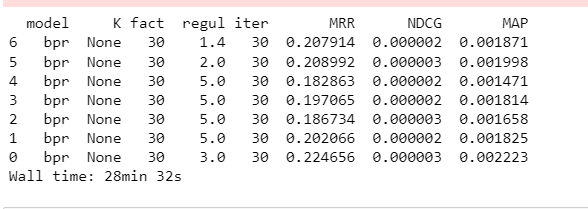
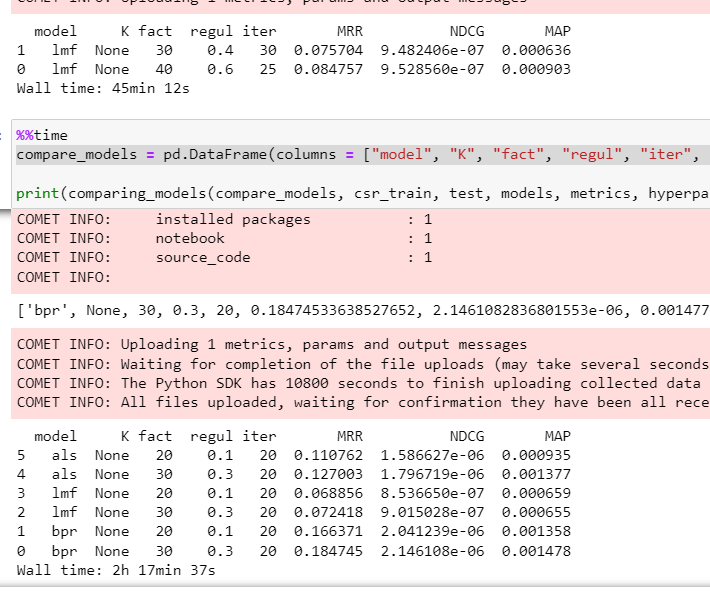

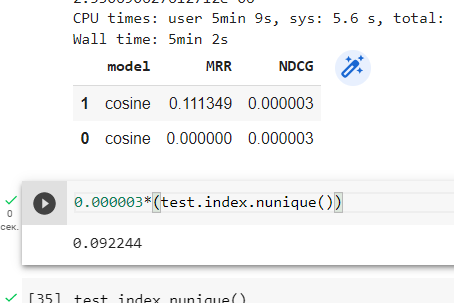

In [ ]:
0.000003*(test.index.nunique())

0.092244

In [ ]:
test.index.nunique()

30748

In [ ]:
%%time

compare_models = pd.DataFrame(columns = ["model", "MRR", "NDCG"])


for model_name, model in models.items():
    rec_df = get_recommenders(model, csr_train, test)
    compare_models.loc[-1] = [model_name]+[0]*(compare_models.shape[1]-1)
    compare_models.index = compare_models.index + 1

    for metric_name, metric in metrics.items():
        m = metric(test, rec_df)
        compare_models[metric_name] = m
        print(m)
compare_models

  0%|          | 0/161 [00:00<?, ?it/s]

0.11134873141833242
0.07781367541783567


  0%|          | 0/20 [00:00<?, ?it/s]

0.07145442160646337
0.048372951778578074
CPU times: user 9min 6s, sys: 33 s, total: 9min 39s
Wall time: 9min 18s


,model,MRR,NDCG
3,cosine,0.071454,0.048373
2,cosine,0.071454,0.048373
1,ALS,0.071454,0.048373
0,ALS,0.000000,0.048373


In [ ]:
test.index = test['user'].apply(lambda x: user2ind[x])

In [ ]:
from sklearn.metrics import ndcg_score
#ndcg = ndcg_score(test, df_reccom)

In [ ]:
df_reccom = df_reccom.explode(["ticker", "similar"])
df_reccom["rank"] = range(df_reccom.shape[0])
df_reccom["rank"] = df_reccom["rank"].apply(lambda x: x%10+1)

In [ ]:
MRR(test.reset_index().drop(["index"], 1), df_reccom)
rank = [1 + list(predict_data['ticker'][user]).index(x) for x in \
        set(predict_data['ticker'][user]).intersection(set(test_data['ticker'][user]))]

[1 + list(df_reccom['ticker'][36]).index(x) for x in \
                    set(df_reccom['ticker'][36]).intersection(set(test['ticker'][36]))]

In [ ]:
#(set(test['ticker'].filter(test.user_id == 4)))
for i in range(0, 100):
    s = set(df_reccom['ticker'][i]).intersection(test.loc[test.user_id == i]["ticker"])
    if len(s)!=0:
        print(i, s)

In [ ]:
set(df_reccom['ticker'][36]).intersection(set(test['ticker'][36]))

In [ ]:
set(test['ticker'][36])

In [ ]:
df_reccom

In [ ]:
test

In [ ]:
test = test.reset_index().drop(["index"], 1)
test.index = test['user'].apply(lambda x: user2ind[x])
test

In [ ]:
df_reccom.index

In [ ]:
rank = [1 + list(df_reccom['ticker'][df_reccom.user_id == 6]).index(x) for x in \
        set(df_reccom['ticker'][df_reccom.user_id == 6]).intersection(set(test['ticker'][df_reccom.user_id == 6]))]

In [ ]:
%%time
print(NDCG(test, df_reccom))

In [ ]:
k = [1, 2, 3]
b = [4, 5, 6]
c = [7, 8, 9]

for (i, d, f) in zip(k, b, c):
    print(i, d, f)